# 학습 데이터 준비

> Coverage
1. Data Sampling
2. Data Labeling에 따른 Learning 유형
2. Class Imbalnce

## 0. Import

In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek

## 1. Data Sampling

In [4]:
df = pd.DataFrame({
    'Age' : np.random.randint(20, 40, 100),
    'Income' : np.random.randint(60000, 100000, 100)
})

df.head()

,Age,Income
0,20,77895
1,23,85343
2,25,61105
3,38,73555
4,37,67759


> Random Sampling

In [7]:
# Random Sampling
rand_samples = df.sample(n=10, random_state=42)

rand_samples

,Age,Income
83,21,98514
53,29,98318
70,24,81412
45,31,66698
44,26,74993
39,22,74566
22,26,93814
80,31,89383
10,24,99502
0,20,77895


> Stratified Sampling

In [10]:
# Stratified Sampling
# 'Age' 컬럼을 기준으로 층화 추출
train, test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['Age']
)

In [11]:
train.describe()

,Age,Income
count,80.000000,80.000000
mean,29.012500,81419.162500
std,5.926755,11535.614569
min,20.000000,61105.000000
25%,24.000000,73185.750000
50%,29.000000,80967.500000
75%,33.250000,91100.750000
max,39.000000,99799.000000


In [12]:
test.describe()

,Age,Income
count,20.000000,20.000000
mean,29.400000,85880.000000
std,5.585696,10046.573367
min,20.000000,60931.000000
25%,24.750000,80939.500000
50%,29.500000,86274.000000
75%,33.250000,94513.000000
max,39.000000,98473.000000


> Cluster Sampling

In [13]:
# Cluster Sampling
# 'Age' 컬럼을 기준으로 클러스터 생성 (연령대별 그룹화)
age_clusters = pd.cut(
    df['Age'], 
    bins=3, 
    labels=['Young', 'Middle', 'Senior']
)

# 클러스터 정보를 데이터프레임에 추가
df['AgeCluster'] = age_clusters

# 각 클러스터별 데이터 개수 확인
print("클러스터별 데이터 분포:")
print(df['AgeCluster'].value_counts())

# 특정 클러스터에서 샘플링 (예: 'Middle' 클러스터에서 5개 샘플)
middle_cluster_sample = df[df['AgeCluster'] == 'Middle'].sample(n=5, random_state=42)
print("\nMiddle 클러스터 샘플:")
print(middle_cluster_sample)

클러스터별 데이터 분포:
AgeCluster
Young     38
Middle    33
Senior    29
Name: count, dtype: int64

Middle 클러스터 샘플:
    Age  Income AgeCluster
98   31   81119     Middle
53   29   98318     Middle
74   30   94452     Middle
55   29   94696     Middle
33   30   64893     Middle


> Weight Sampling

In [15]:
weights = np.random.rand(len(df))

weighted_rand_samples = df.sample(n=10, random_state=42, weights=weights)

weighted_rand_samples

,Age,Income,AgeCluster
39,22,74566,Young
95,21,68470,Young
72,25,80901,Young
58,25,92066,Young
16,29,66281,Middle
6,25,60931,Young
89,30,86400,Middle
59,39,71062,Senior
69,27,82931,Middle
2,25,61105,Young


> Importance Sampling

weight sampling의 특별한 경우, 특정 함수의 기대값을 추정하는 데 사용하는 샘플링 방식

In [17]:
def importance_func(val):
    return val**2

importances = importance_func(df['Income'])
normalized_importances = importances / importances.sum()
importance_samples = df.sample(n=10, random_state=42, weights=normalized_importances)
importance_samples

,Age,Income,AgeCluster
36,26,99411,Young
94,25,77780,Young
73,30,90779,Middle
60,39,77065,Senior
16,29,66281,Middle
7,34,95912,Senior
86,25,86048,Young
61,30,81034,Middle
71,32,87158,Middle
1,23,85343,Young


## 2. Data Labeling 에 따른 Learning 유형

In [21]:
data = load_iris()

> Supervised Learning

In [22]:
train_input, test_input, train_target, test_target = train_test_split(
    data.data,
    data.target,
    test_size=0.2,
    random_state=42,
    stratify=data.target
)

In [28]:
dt_clf = DecisionTreeClassifier(random_state=42)

dt_clf.fit(train_input, train_target)

pred = dt_clf.predict(test_input)

pd.DataFrame(confusion_matrix(test_target, pred))

,0,1,2
0,10,0,0
1,0,9,1
2,0,1,9


> UnSupervised Learning

In [34]:
kmeans_clf = KMeans(n_clusters=3, random_state=42)

kmeans_clf.fit(train_input)

pred = kmeans_clf.predict(test_input)

In [35]:
pd.DataFrame(confusion_matrix(test_target, pred))

,0,1,2
0,10,0,0
1,0,9,1
2,0,2,8


> Semi-Supervised_Learning

In [38]:
labels = np.copy(train_target)
rand_unlabeled_points = np.random.rand(len(labels)) < 0.5
labels[rand_unlabeled_points] = -1

lp_clf = LabelSpreading()
lp_clf.fit(train_input, labels)

pred = lp_clf.predict(test_input)

pd.DataFrame(confusion_matrix(test_target, pred))

,0,1,2
0,10,0,0
1,0,10,0
2,0,1,9


## 3. Class Imbalanced

In [45]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'class_imbalance', 'winequality_for_class_imbalance.csv'), index_col='Unnamed: 0')
labels = np.load(os.path.join(os.getcwd(), 'data', 'class_imbalance', 'winequality_for_class_imbalance_label.npy'))

In [46]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,-0.165087,-0.440021,0.280208,3.477382,-0.316815,0.838865,0.984149,2.177419,-1.401186,-0.555267,-1.475154,0,1
1,-0.695163,-0.261684,0.144245,-0.766859,-0.208407,-0.900220,0.314921,-0.180598,0.472180,-0.288309,-0.885144,0,1
2,0.667890,-0.380575,0.552136,0.410863,-0.181305,-0.002628,-0.301474,0.189947,0.222398,-0.622007,-0.379421,0,1
3,-0.013636,-0.677803,0.008281,0.766401,0.035512,0.951064,1.265929,0.358377,-0.214721,-0.888964,-0.547996,0,1
4,-0.770888,-0.142793,-1.079428,0.433084,-0.316815,-0.002628,0.385366,0.122576,-0.277166,-0.421788,-0.800857,0,1


In [47]:
labels

array([3, 3, 3, ..., 2, 2, 3], shape=(5295,))

In [48]:
train_input, test_input, train_target, test_target = train_test_split(
    df, labels,
    test_size=0.2,
    stratify=labels
)

> Over Sapling : SMOTE

In [49]:
smote = SMOTE(random_state=42, k_neighbors=3)
smote_resampled_train_input, smote_resampled_train_target = smote.fit_resample(train_input, train_target)

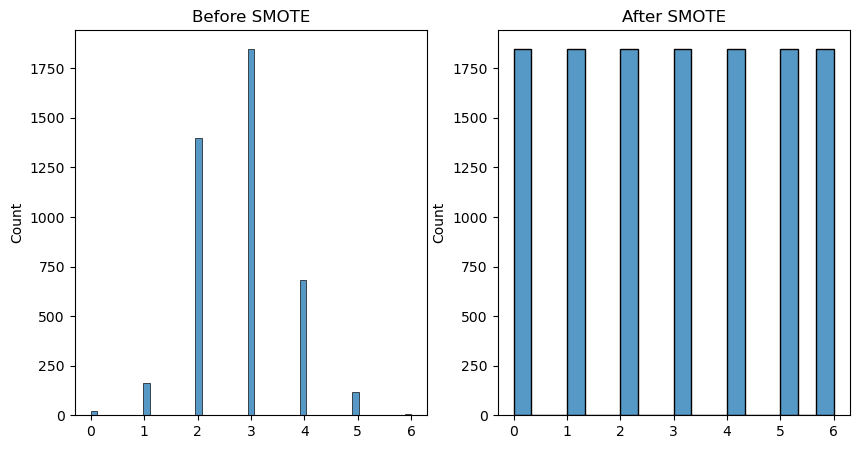

In [51]:
fig = plt.figure(figsize=(10,5))

fig.add_subplot(1,2,1)
sns.histplot(train_target)
plt.title('Before SMOTE')

fig.add_subplot(1,2,2)
sns.histplot(smote_resampled_train_target)
plt.title('After SMOTE')

plt.show()

> Over Sampling : ADASYN

In [54]:
adasyn = ADASYN(random_state=42, n_neighbors=3)

adasyn_resampled_train_input, adasyn_resampled_train_target = adasyn.fit_resample(train_input, train_target)

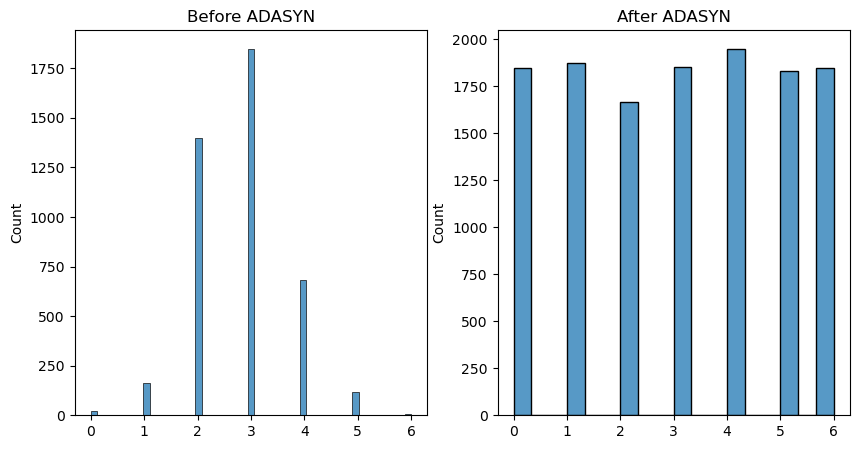

In [55]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
sns.histplot(train_target)
plt.title('Before ADASYN')

fig.add_subplot(1,2,2)
sns.histplot(adasyn_resampled_train_target)
plt.title('After ADASYN')

plt.show()

> Under Sampling : Random Under Sampling

Text(0.5, 1.0, 'After RandomUnderSampler')

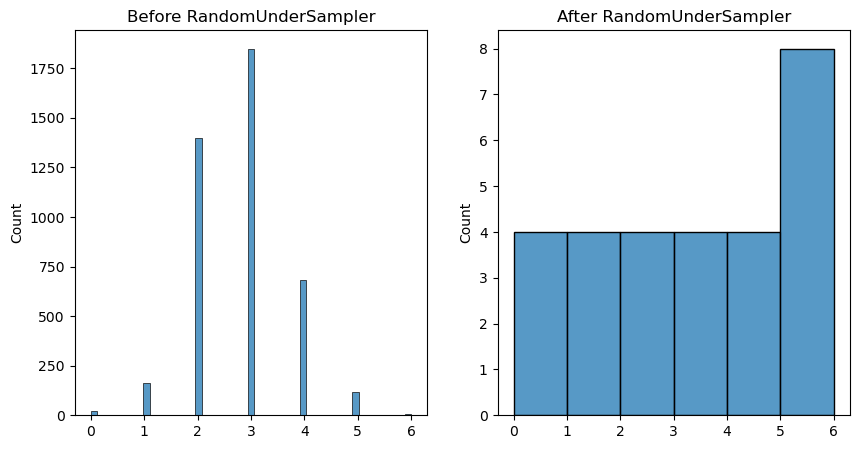

In [67]:
rus = RandomUnderSampler(random_state=42)
rus_resampled_train_input, rus_resampled_train_target = rus.fit_resample(train_input, train_target)

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
sns.histplot(train_target)
plt.title('Before RandomUnderSampler')

fig.add_subplot(1,2,2)
sns.histplot(rus_resampled_train_target)
plt.title('After RandomUnderSampler')

> Under Sampling : TomekLinks

Text(0.5, 1.0, 'After TomekLinks')

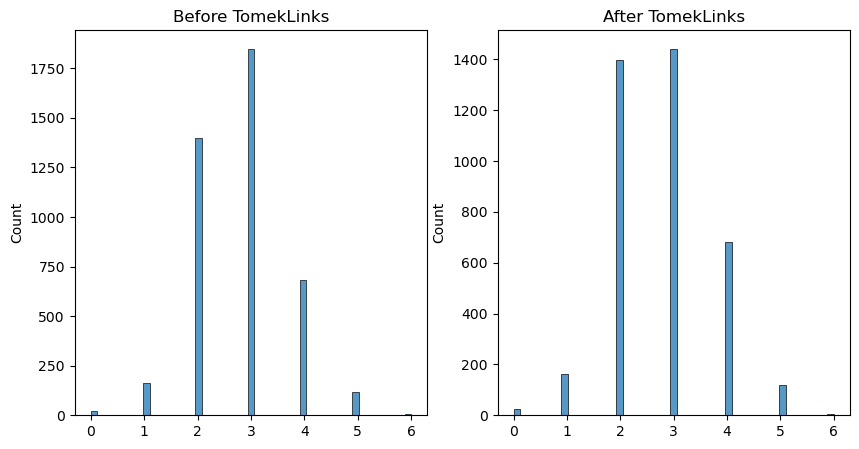

In [70]:
tomek = TomekLinks(sampling_strategy='majority')
tomek_resampled_train_input, tomek_resampled_train_target = tomek.fit_resample(train_input, train_target)

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
sns.histplot(train_target)
plt.title('Before TomekLinks')

fig.add_subplot(1,2,2)
sns.histplot(tomek_resampled_train_target)
plt.title('After TomekLinks')

> Under Sampling : EditedNearestNeighbours(ENN)

Text(0.5, 1.0, 'After EditedNearestNeighbours')

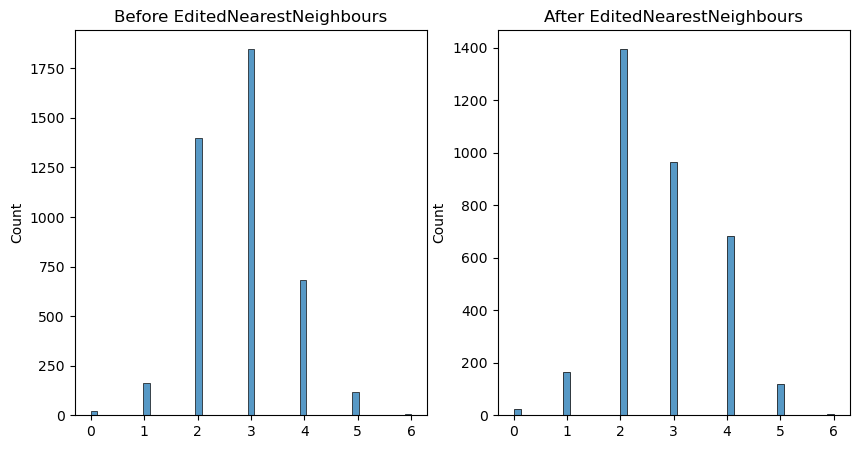

In [73]:
enn = EditedNearestNeighbours(n_neighbors=3, kind_sel='mode', sampling_strategy='majority')
enn_resampled_train_input, enn_resampled_train_target = enn.fit_resample(train_input, train_target)

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
sns.histplot(train_target)
plt.title('Before EditedNearestNeighbours')

fig.add_subplot(1,2,2)
sns.histplot(enn_resampled_train_target)
plt.title('After EditedNearestNeighbours')

> Combine Samling : SMOTEENN

Text(0.5, 1.0, 'After SMOTEENN')

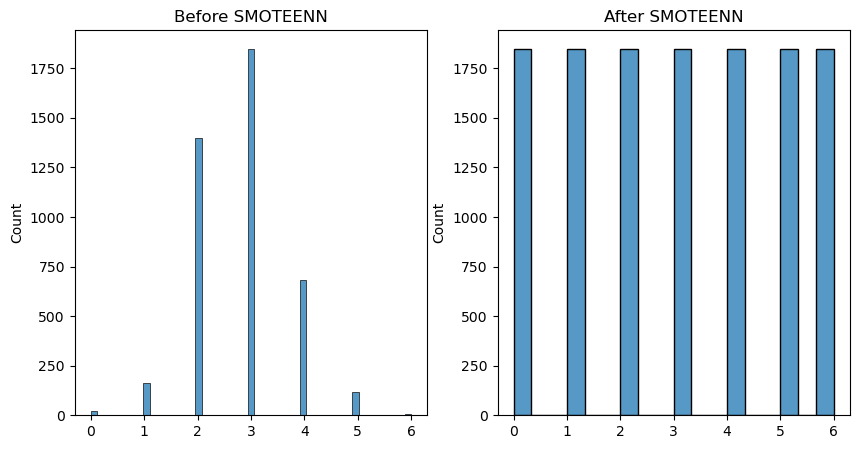

In [79]:
smote = SMOTE(random_state=42, k_neighbors=3)
enn = EditedNearestNeighbours(n_neighbors=3, kind_sel='mode', sampling_strategy='majority')
smote_enn = SMOTEENN(random_state=42, smote=smote, enn=enn)
smote_enn_resampled_train_input, smote_enn_resampled_train_target = smote_enn.fit_resample(train_input, train_target)

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
sns.histplot(train_target)
plt.title('Before SMOTEENN')

fig.add_subplot(1,2,2)
sns.histplot(smote_enn_resampled_train_target)
plt.title('After SMOTEENN')

Text(0.5, 1.0, 'After SMOTETomek')

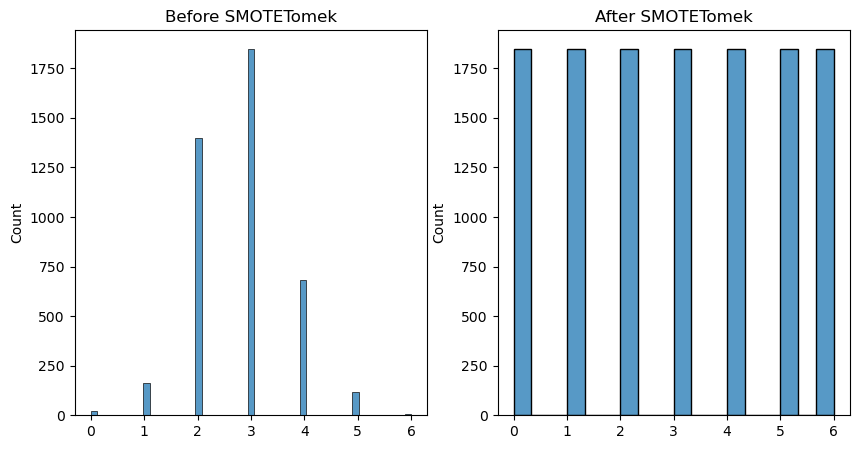

In [80]:
smote = SMOTE(random_state=42, k_neighbors=3)
tomek = TomekLinks(sampling_strategy='majority')
smote_tomek = SMOTETomek(random_state=42, smote=smote, tomek=tomek)

smote_tomek_resampled_train_input, smote_tomek_resampled_train_target = smote_tomek.fit_resample(train_input, train_target)

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
sns.histplot(train_target)
plt.title('Before SMOTETomek')

fig.add_subplot(1,2,2)
sns.histplot(smote_tomek_resampled_train_target)
plt.title('After SMOTETomek')